In [1]:
from google.cloud import storage
import argparse
import gzip
import os
import sys
import time
from multiprocessing import Pool

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

from utils import gcs_utils as gcs
from utils import model_and_evaluate_cluster as ev
import urllib.parse
import urllib.request

import io 

import importlib
import hdbscan
import networkx as nx 
import pickle

import obonet
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
goa = pd.read_csv( io.BytesIO(gcs.download_blob("functional_sim/data/goa_human.gaf.gz")), 
                                compression='gzip', 
                                header=None,
                                skiprows=41,    # hard-coded. May be different for other gaf files.
                                sep='\t')

goa.columns=["DB", "DB Object ID", "DB Object Symbol", "Qualifier", "GO ID", "Reference", 
                         "Evidence Code", "With or From", "Aspect", "Name", "Synonym", "Type", 
                         "Taxon", "Date", "Assigned By", "Annotation Extension", "Gene Product Form ID"]


/Users/haeranglee/opt/anaconda3/envs/pss/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
all_protein_combos_per_cluster = gcs.download_parquet(
    'model_outputs/no_cluster_size_limit/B3EP_A-HDBSCAN-CurveNet-all_protein_combos_per_cluster.parquet')

## Comparison Model: C3EP_B

In [13]:
all_protein_combos_per_cluster2 = gcs.download_parquet('model_outputs/no_cluster_size_limit/C3EP_B-OPTICS-Novel-COS-2-all_protein_combos_per_cluster.parquet')


In [16]:
funsim_result2 = ev.funsim_evaluator(all_protein_combos_per_cluster2, goa)

2021-Dec-06 18:17:42 Total number of proteins in GO annotations: 18240
2021-Dec-06 18:17:42 IC_t created
2021-Dec-06 18:17:43 Dictionary of proteins and their GO terms lookup created


In [17]:
funsim_result2.funsim()
cluster_funsim2, protein_pair_funsim2 = funsim_result2.cluster_funsim, funsim_result2.protein_pair_funsim

2021-Dec-06 18:18:11 Funsim calculated.
2021-Dec-06 18:18:11 Funsim summary by cluster done.
2021-Dec-06 18:18:11 Get NP Arr of GO terms for each protein
2021-Dec-06 18:18:11 Turn GO terms into dict
2021-Dec-06 18:18:11 Map GO desc...
2021-Dec-06 18:18:11 Mapping GO desc done.
2021-Dec-06 18:18:12 Common GO term sumary per cluster processed.
2021-Dec-06 18:18:12 Merged cluster-level funsim score with GO summary.


In [19]:
all_protein_combos_per_cluster2.head()

,query_protein,target_protein,cluster,protein_A,protein_B
0,Q9NYQ6,Q5T1H1,0,Q5T1H1,Q9NYQ6
1,Q9NYQ6,Q9HCU4,0,Q9HCU4,Q9NYQ6
2,Q9NYQ6,Q9NYQ7,0,Q9NYQ6,Q9NYQ7
3,Q5T1H1,Q9NYQ6,0,Q5T1H1,Q9NYQ6
4,Q5T1H1,Q9HCU4,0,Q5T1H1,Q9HCU4


# Make cluster_stats from Best Model

Or import: `cluster_stats = gcs.download_parquet('mvp_input/2021_1204/cluster_stats_haerang.parquet')`

In [35]:
cluster_stats_1 = gcs.download_parquet('mvp_input/2021_1204/B3EP_A-HDBSCAN-CurveNet-cluster_stats.parquet')
# take out 'bitscore_mean', 'bitscore_std_dev','evalue_mean', 'evalue_std_dev', 
cluster_stats_1 = cluster_stats_1 [['model', 'embedding', 'num_proteins', 'D_perc', 'protein_confidence',
       'mean_seq_len', 'min_seq_len', 'median_seq_len', 'max_seq_len',
       'std_seq_len', 'seq_len_arr', 'ratio_pairs_wo_blast']]

In [36]:
cluster_stats_2 = pd.read_csv(io.BytesIO(gcs.download_blob('mvp_input/2021_1204/cluster_funsim.csv')))

In [24]:
cluster_stats_3 = gcs.download_parquet('mvp_input/2021_1204/B3EP_A_PairwiseStats.parquet')
cluster_stats_3 = cluster_stats_3.fillna(0)
cluster_stats_3 = cluster_stats_3.pivot_table(index='cluster',
                           values='bitscore_mean',
                           aggfunc=np.mean).reset_index()

In [37]:
cluster_stats_1.shape

(834, 12)

In [38]:
cluster_stats_2.shape

(833, 13)

In [39]:
cluster_stats_3.shape

(833, 2)

In [40]:
pairwise_eval = gcs.download_parquet('mvp_input/2021_1204/B3EP_A_PairwiseStats.parquet')

In [41]:
pairwise_eval.head()

,query_protein,target_protein,cluster,query_protein_length,target_protein_length,aligned_length,rmsd,tmalign_score,hit_span_mean,bitscore_mean,evalue_mean
0,AF-Q92851-F1-model_v1,AF-Q99538-F1-model_v1,0,521.0,433.0,182.0,4.11,0.30039,NaN,NaN,NaN
1,AF-Q92851-F1-model_v1,AF-P49662-F1-model_v1,0,521.0,377.0,250.0,4.28,0.41562,221.0,65.9,1.680000e-11
2,AF-Q92851-F1-model_v1,AF-O15519-F1-model_v1,0,521.0,480.0,191.0,3.11,0.33610,440.0,105.0,2.920000e-24
3,AF-Q92851-F1-model_v1,AF-Q14790-F1-model_v1,0,521.0,479.0,248.0,4.43,0.41147,435.0,241.0,1.460000e-73
4,AF-Q92851-F1-model_v1,AF-P55211-F1-model_v1,0,521.0,416.0,215.0,3.81,0.37304,216.0,114.0,1.490000e-27


In [42]:
cluster_eval = pairwise_eval.pivot_table(
    index='cluster',
    values=['rmsd', 'tmalign_score'],
    aggfunc=np.mean
)

cluster_eval

,rmsd,tmalign_score
cluster,,
0,2.982583,0.535021
1,3.680000,0.459959
2,3.290000,0.748890
3,3.248725,0.532235
6,6.368667,0.592625
...,...,...
828,4.855155,0.429232
829,6.169636,0.278712
830,4.864167,0.294018


In [43]:
cluster_stats_3.head()

,cluster,bitscore_mean
0,0,76.812917
1,1,42.967803
2,2,107.760000
3,3,22.135968
4,4,43.975000


In [44]:
cluster_stats = cluster_stats_1[['num_proteins', 'D_perc', 'protein_confidence',
       'median_seq_len',
       'std_seq_len']
    ].merge(cluster_stats_2[['cluster', 'funsim']],
            left_index=True,
            right_on='cluster'
    ).merge(cluster_eval,
           left_index=True,
           right_index=True,
           how='left'
    ).merge(cluster_stats_3,
            left_index=True,
            right_on='cluster'
    )

In [45]:
cluster_stats

,cluster,num_proteins,D_perc,protein_confidence,median_seq_len,std_seq_len,cluster_x,funsim,rmsd,tmalign_score,cluster_y,bitscore_mean
0,0,16,0.160317,80.669787,410.0,134.827034,0,0.293619,2.982583,0.535021,0,76.812917
1,1,12,0.099938,81.643986,343.5,182.813595,1,0.056360,3.680000,0.459959,1,42.967803
2,2,5,0.106305,79.897790,299.0,43.031384,2,1.000000,3.290000,0.748890,2,107.760000
3,3,23,0.083594,88.840144,222.0,85.656198,3,0.079149,3.248725,0.532235,3,22.135968
4,4,5,0.229143,78.375650,298.0,96.391390,4,0.132348,NaN,NaN,4,43.975000
...,...,...,...,...,...,...,...,...,...,...,...,...
828,828,423,0.299617,67.539479,561.0,161.669876,828,0.513221,4.855155,0.429232,828,268.612296
829,829,9,0.358227,62.367330,619.0,458.157451,829,0.272137,6.169636,0.278712,829,74.956467
830,830,5,0.259113,75.345309,488.0,123.603398,830,0.247875,4.864167,0.294018,830,21.460000
831,831,18,0.219954,74.440214,832.5,589.531918,831,0.063514,6.452989,0.250113,831,11.899020


In [46]:
cluster_stats['bitscore_good'] = cluster_stats.bitscore_mean > 50
cluster_stats['tmalign_good'] = cluster_stats.tmalign_score > 0.5
cluster_stats['rmsd_good'] = cluster_stats.rmsd < 3.
cluster_stats.to_parquet('mvp_input/cluster_stats_haerang.parquet')

# Start here with `cluster_stats`

In [4]:
cluster_stats = gcs.download_parquet('mvp_input/2021_1204/cluster_stats_haerang.parquet')

In [5]:
cluster_stats.columns

Index(['cluster', 'num_proteins', 'D_perc', 'protein_confidence',
       'median_seq_len', 'std_seq_len', 'cluster_x', 'funsim', 'rmsd',
       'tmalign_score', 'cluster_y', 'bitscore_mean', 'bitscore_good',
       'tmalign_good', 'rmsd_good'],
      dtype='object')

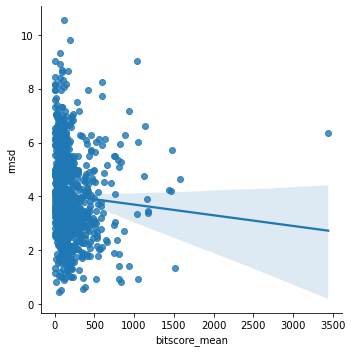

In [48]:
sns.lmplot(data=cluster_stats, 
                x="bitscore_mean", 
                y='rmsd'
               )

<AxesSubplot:xlabel='bitscore_mean', ylabel='rmsd'>

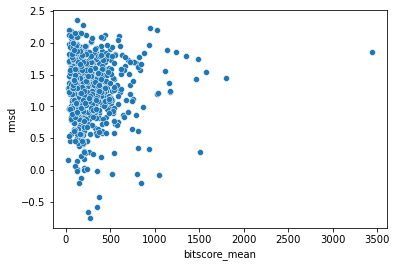

In [311]:
sns.scatterplot(data=cluster_stats, 
                x="bitscore_mean", 
                y=np.log(cluster_stats["rmsd"])
               )

(0.0, 2000.0)

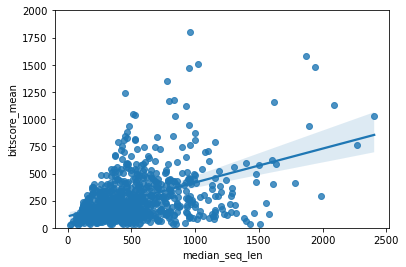

In [426]:
data=cluster_stats[cluster_stats.median_seq_len < 8000]
x="median_seq_len"
y="bitscore_mean"

p = sns.regplot(data=cluster_stats[
    cluster_stats.median_seq_len < 8000], 
           x=x,
           y=y,
               )
p.set_ylim(0, 2000)
              

(0.0, 2000.0)

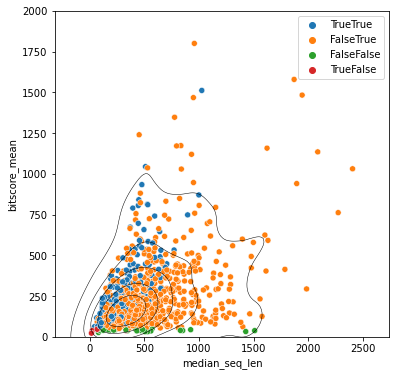

In [433]:
data=cluster_stats[cluster_stats.median_seq_len < 8000]
x="median_seq_len"
y="bitscore_mean"

f, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(data=data, x=x, y=y,
                    hue=(cluster_stats.rmsd_good.astype(str) 
                         + cluster_stats.bitscore_good.astype(str))
               )
sns.kdeplot(data=data, x=x, y=y, 
            levels=6, color="k", linewidths=0.5)
ax.set_ylim(0, 2000)

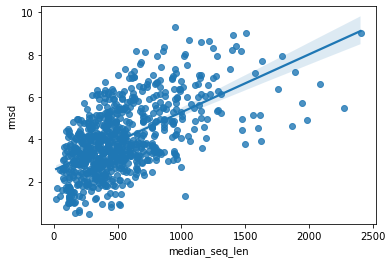

In [421]:
p = sns.regplot(data=cluster_stats[
    cluster_stats.median_seq_len < 8000],  
           x="median_seq_len",
           y="rmsd",
               )
              

<AxesSubplot:xlabel='median_seq_len', ylabel='rmsd'>

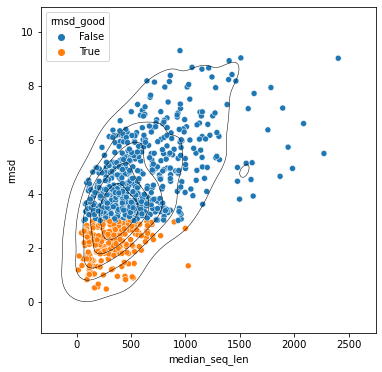

In [423]:
data=cluster_stats[cluster_stats.median_seq_len < 8000]
x="median_seq_len"
y="rmsd"

f, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(data=data, x=x, y=y,
                    hue=(cluster_stats.rmsd_good)
               )
sns.kdeplot(data=data, x=x, y=y, 
            levels=6, color="k", linewidths=0.5)

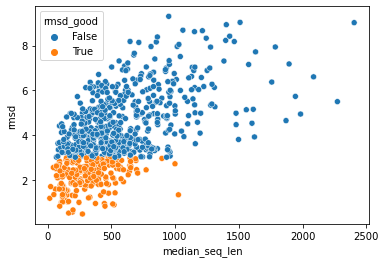

In [424]:
p = sns.scatterplot(data=cluster_stats[
    cluster_stats.median_seq_len < 8000],   
           x="median_seq_len",
           y="rmsd",
           hue='rmsd_good'
               )

<AxesSubplot:xlabel='median_seq_len', ylabel='tmalign_score'>

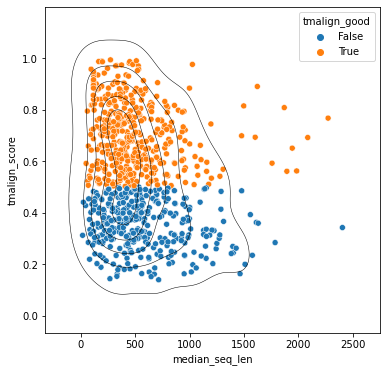

In [11]:
data=cluster_stats[cluster_stats.median_seq_len < 8000]
x="median_seq_len"
y="tmalign_score"

f, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(data=data, x=x, y=y,
                    hue=(cluster_stats.tmalign_good)
               )
sns.kdeplot(data=data, x=x, y=y, 
            levels=6, color="k", linewidths=0.5)

(0.0, 10.0)

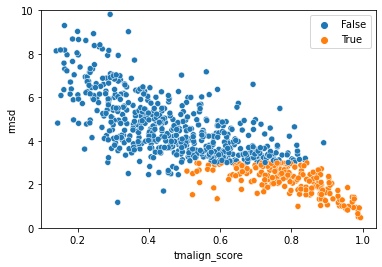

In [7]:
p = sns.scatterplot(data=cluster_stats, 
                    x="tmalign_score",
                    y="rmsd",
                    hue=(cluster_stats.rmsd_good
                        ) & (cluster_stats.tmalign_good)
               
                   )
p.set_ylim(0, 10)

<AxesSubplot:xlabel='tmalign_score', ylabel='rmsd'>

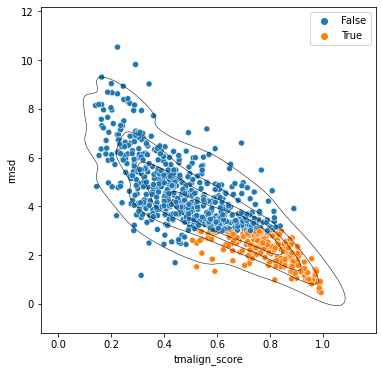

In [406]:
data, x, y = (cluster_stats, "tmalign_score", "rmsd")

f, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(data=data, x=x, y=y,
                    hue=(cluster_stats.rmsd_good
                        ) & (cluster_stats.tmalign_good)
               )
sns.kdeplot(data=data, x=x, y=y, 
            levels=5, color="k", linewidths=0.5)

[Text(0.5, 0, 'Tmalign score'),
 Text(0, 0.5, 'Rmsd'),
 Text(0.5, 1.0, 'Tmalign score vs. Rmsd')]

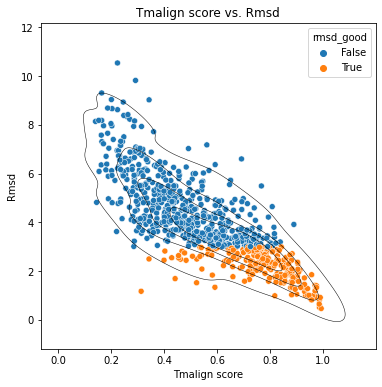

In [52]:
data, x, y = (cluster_stats, "tmalign_score", "rmsd")

f, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(data=data, x=x, y=y,
                    hue=(cluster_stats.rmsd_good)
               )
sns.kdeplot(data=data, x=x, y=y, 
            levels=5, color="k", linewidths=0.5)



x_proper = x.capitalize().replace('_', ' ')
y_proper = y.capitalize().replace('_', ' ')
ax.set(xlabel=x_proper, 
       ylabel=y_proper,
      title =x_proper + " vs. " + y_proper)



[Text(0.5, 0, 'Tmalign score'),
 Text(0, 0.5, 'Rmsd'),
 Text(0.5, 1.0, 'Tmalign score vs. Rmsd')]

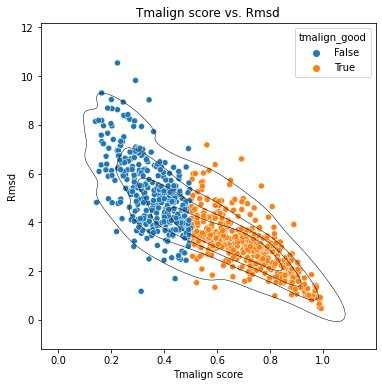

In [51]:
data, x, y = (cluster_stats, "tmalign_score", "rmsd")

f, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(data=data, x=x, y=y,
                    hue=(cluster_stats.tmalign_good)
               )
sns.kdeplot(data=data, x=x, y=y, 
            levels=5, color="k", linewidths=0.5)


x_proper = x.capitalize().replace('_', ' ')
y_proper = y.capitalize().replace('_', ' ')
ax.set(xlabel=x_proper, 
       ylabel=y_proper,
      title =x_proper + " vs. " + y_proper)



[Text(0.5, 0, 'Tmalign score'),
 Text(0, 0.5, 'Rmsd'),
 Text(0.5, 1.0, 'Tmalign score vs. Rmsd')]

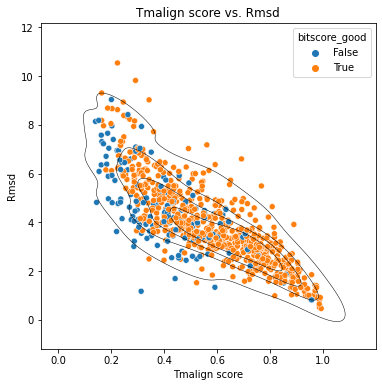

In [50]:
data, x, y = (cluster_stats, "tmalign_score", "rmsd")

f, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(data=data, x=x, y=y,
                    hue=(cluster_stats.bitscore_good)
               )
sns.kdeplot(data=data, x=x, y=y, 
            levels=5, color="k", linewidths=0.5)

x_proper = x.capitalize().replace('_', ' ')
y_proper = y.capitalize().replace('_', ' ')
ax.set(xlabel=x_proper, 
       ylabel=y_proper,
      title =x_proper + " vs. " + y_proper)



In [344]:
cluster_stats.tmalign_score.describe()

count    774.000000
mean       0.550104
std        0.208400
min        0.140095
25%        0.377097
50%        0.544007
75%        0.718766
max        0.993640
Name: tmalign_score, dtype: float64

<AxesSubplot:xlabel='median_seq_len', ylabel='bitscore_mean'>

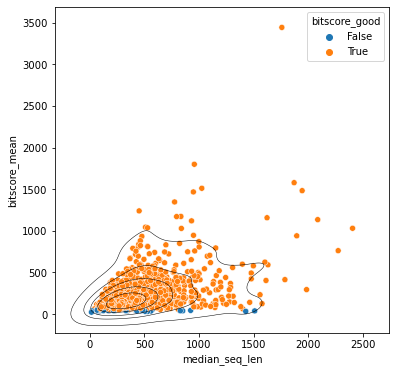

In [417]:
data=cluster_stats[cluster_stats.median_seq_len < 8000]
x="median_seq_len"
y="bitscore_mean"

f, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(data=data, x=x, y=y,
                hue=(cluster_stats.bitscore_good),
                )
f.set_ylim=(-200, 2000)
sns.kdeplot(data=data, x=x, y=y, 
            levels=6, color="k", linewidths=0.5)


<AxesSubplot:xlabel='bitscore_mean', ylabel='median_seq_len'>

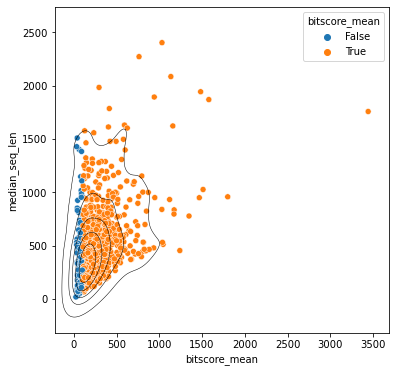

In [416]:
data=cluster_stats[cluster_stats.median_seq_len < 8000]
x="bitscore_mean"
y="median_seq_len"

f, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(data=data, x=x, y=y,
                hue=(cluster_stats.bitscore_mean > 100),
                )
f.set_xlim=(-200, 2000)
sns.kdeplot(data=data, x=x, y=y, 
            levels=6, color="k", linewidths=0.5)


<AxesSubplot:>

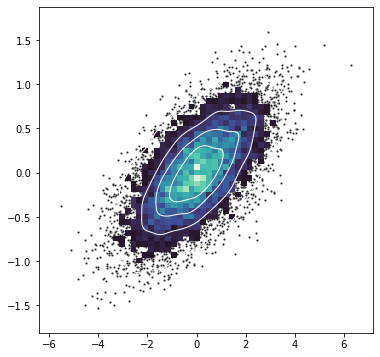

In [384]:

# Simulate data from a bivariate Gaussian
n = 10000
mean = [0, 0]
cov = [(2, .4), (.4, .2)]
rng = np.random.RandomState(0)
x, y = rng.multivariate_normal(mean, cov, n).T

# Draw a combo histogram and scatterplot with density contours
f, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(x=x, y=y, s=5, color=".15")
sns.histplot(x=x, y=y, bins=50, pthresh=.1, cmap="mako")
sns.kdeplot(x=x, y=y, levels=5, color="w", linewidths=1)

<AxesSubplot:>

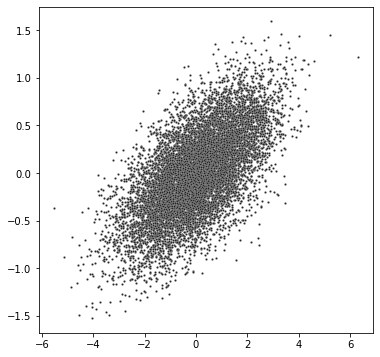

In [385]:
f, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(x=x, y=y, s=5, color=".15")


<AxesSubplot:>

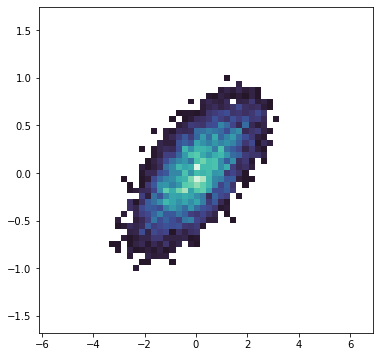

In [386]:
f, ax = plt.subplots(figsize=(6, 6))
# sns.scatterplot(x=x, y=y, s=5, color=".15")
sns.histplot(x=x, y=y, bins=50, pthresh=.1, cmap="mako")
# sns.kdeplot(x=x, y=y, levels=5, color="w", linewidths=1)

<AxesSubplot:>

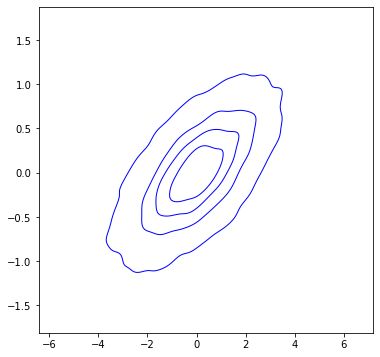

In [388]:
f, ax = plt.subplots(figsize=(6, 6))
# sns.scatterplot(x=x, y=y, s=5, color=".15")
# sns.histplot(x=x, y=y, bins=50, pthresh=.1, cmap="mako")
sns.kdeplot(x=x, y=y, levels=5, color="b", linewidths=1)

# Discoveries


In [140]:
pws= gcs.download_parquet('mvp_input/2021_1204/B3EP_A_PairwiseStats.parquet')
pws[['bitscore_mean', 'evalue_mean']] = pws[['bitscore_mean', 'evalue_mean']].fillna(0)
pws.query_protein=pws.query_protein.str.split('-', expand=True)[1]
pws.target_protein=pws.target_protein.str.split('-', expand=True)[1]
pws.head()

,query_protein,target_protein,cluster,query_protein_length,target_protein_length,aligned_length,rmsd,tmalign_score,hit_span_mean,bitscore_mean,evalue_mean
0,Q92851,Q99538,0,521.0,433.0,182.0,4.11,0.30039,NaN,0.0,0.000000e+00
1,Q92851,P49662,0,521.0,377.0,250.0,4.28,0.41562,221.0,65.9,1.680000e-11
2,Q92851,O15519,0,521.0,480.0,191.0,3.11,0.33610,440.0,105.0,2.920000e-24
3,Q92851,Q14790,0,521.0,479.0,248.0,4.43,0.41147,435.0,241.0,1.460000e-73
4,Q92851,P55211,0,521.0,416.0,215.0,3.81,0.37304,216.0,114.0,1.490000e-27



## Which protein was previously not in AlphaFold?

`uniprot-organism Homo+sapiens+(Human)+9606-AlphaFoldFiltered.parquet`

Downloaded [UniProtKB 2021_03 results (Filtered by Human)](https://www.uniprot.org/uniprot/?query=organism%3A%22Homo+sapiens+%28Human%29+%5B9606%5D%22&sort=id&desc=no) on Nov 14, 2021. Filtered by the overlapping proteins with AlphaFold. Added an indicator for whether a 3d structure exists. If there is a structure information, that means uniprot had a 3D structure other than those predicted by AlphaFold.

The 3D structure methods are one of:
['X-ray crystallography',
 'NMR spectroscopy',
 'Electron microscopy',
 'Model',
 'Infrared spectroscopy']

In [14]:
uniprot = pd.read_csv("uniprot-organism Homo+sapiens+(Human)+[9606] .tab.gz",
                sep='\t')


In [15]:
uniprot.shape

(202160, 10)

In [16]:
uniprot.head()

,Entry,Entry name,Status,Protein names,Gene names,Annotation,Keywords,Gene ontology (molecular function),3D,Gene ontology IDs
0,X6RM59,X6RM59_HUMAN,unreviewed,5'-nucleotidase (EC 3.1.3.5),NT5C3A,2 out of 5,Cytoplasm;Hydrolase;Metal-binding;Nucleotide m...,5'-nucleotidase activity [GO:0008253]; magnesi...,NaN,GO:0000166; GO:0000287; GO:0005737; GO:0008253...
1,X6RM24,X6RM24_HUMAN,unreviewed,Mitochondrial enolase superfamily member 1 (Fr...,ENOSF1,1 out of 5,Proteomics identification;Reference proteome,NaN,NaN,NaN
2,X6RM00,X6RM00_HUMAN,unreviewed,ELKS/Rab6-interacting/CAST family member 1,ERC1,1 out of 5,Coiled coil;Cytoplasm;Phosphoprotein;Proteomic...,NaN,NaN,GO:0005737
3,X6RLY7,X6RLY7_HUMAN,unreviewed,Voltage-dependent calcium channel subunit alph...,CACNA2D4,1 out of 5,Reference proteome,NaN,NaN,NaN
4,X6RLX0,X6RLX0_HUMAN,unreviewed,ELKS/Rab6-interacting/CAST family member 1,ERC1,1 out of 5,Coiled coil;Cytoplasm;Membrane;Phosphoprotein;...,NaN,NaN,GO:0005737; GO:0016020


In [70]:
uniprot.loc[:, "has_3d"] = ~uniprot["3D"].isna()
uniprot["has_3d"].value_counts()

False    194704
True       7456
Name: has_3d, dtype: int64

In [71]:
test=list(uniprot["3D"].dropna().unique())

test2 = []
for item in test:
    val = item.split(' (')[0]
#     print(val)
    if val not in test2:
        test2.append(val)
test2

['Electron microscopy',
 'X-ray crystallography',
 'NMR spectroscopy',
 'Model',
 'Infrared spectroscopy']

AlphaFold prediction would show up as 'predicted'.

In [73]:
uniprot[uniprot["3D"].fillna('').str.contains('Model')][:5]

,Entry,Entry name,Status,Protein names,Gene names,Annotation,Keywords,Gene ontology (molecular function),3D,Gene ontology IDs,has_3d
6252,Q9Y6Y9,LY96_HUMAN,reviewed,Lymphocyte antigen 96 (Ly-96) (ESOP-1) (Protei...,LY96 ESOP1 MD2,5 out of 5,3D-structure;Alternative splicing;Disulfide bo...,coreceptor activity [GO:0015026]; lipopolysacc...,X-ray crystallography (6); Model (1),GO:0001530; GO:0001875; GO:0002224; GO:0002755...,True
6437,Q9Y5Y6,ST14_HUMAN,reviewed,Suppressor of tumorigenicity 14 protein (EC 3....,ST14 PRSS14 SNC19 TADG15,5 out of 5,3D-structure;Disease variant;Disulfide bond;Gl...,serine-type endopeptidase activity [GO:0004252...,X-ray crystallography (23); Model (1),GO:0001843; GO:0004252; GO:0005615; GO:0005886...,True
7047,Q9Y233,PDE10_HUMAN,reviewed,"cAMP and cAMP-inhibited cGMP 3',5'-cyclic phos...",PDE10A,5 out of 5,3D-structure;Allosteric enzyme;Alternative spl...,"3',5'-cyclic-AMP phosphodiesterase activity [G...",X-ray crystallography (97); Model (1),GO:0004114; GO:0004115; GO:0004118; GO:0005829...,True
8022,Q9UIK5,TEFF2_HUMAN,reviewed,Tomoregulin-2 (TR-2) (Hyperplastic polyposis p...,TMEFF2 HPP1 TENB2 TPEF UNQ178/PRO204,5 out of 5,3D-structure;Alternative splicing;Direct prote...,NaN,Model (1),GO:0005576; GO:0005604; GO:0005886; GO:0009887...,True
8130,Q9UHV8,PP13_HUMAN,reviewed,Galactoside-binding soluble lectin 13 (Galecti...,LGALS13 PLAC8,5 out of 5,3D-structure;Apoptosis;Cytoplasm;Disulfide bon...,carbohydrate binding [GO:0030246]; lysophospho...,X-ray crystallography (11); Model (1),GO:0004622; GO:0005654; GO:0005737; GO:0006644...,True


In [74]:
pws.shape

(596318, 13)

In [142]:
# Map in whether 3d structure outside of AlphaFold exists

pws = pws.merge(uniprot[['Entry', 'has_3d']].set_index('Entry'),
         how='left',
         left_on='query_protein',
         right_index=True)

pws.rename(columns={'has_3d': 'query_has_3d'}, inplace=True)

pws = pws.merge(uniprot[['Entry', 'has_3d']].set_index('Entry'),
         how='left',
         left_on='target_protein',
         right_index=True)

pws.rename(columns={'has_3d': 'target_has_3d'}, inplace=True)

In [98]:
pws.head()

,query_protein,target_protein,cluster,query_protein_length,target_protein_length,aligned_length,rmsd,tmalign_score,hit_span_mean,bitscore_mean,evalue_mean,query_has_3d,target_has_3d
0,Q92851,Q99538,0,521.0,433.0,182.0,4.11,0.30039,0.0,0.0,0.000000e+00,False,True
1,Q92851,P49662,0,521.0,377.0,250.0,4.28,0.41562,221.0,65.9,1.680000e-11,False,True
2,Q92851,O15519,0,521.0,480.0,191.0,3.11,0.33610,440.0,105.0,2.920000e-24,False,True
3,Q92851,Q14790,0,521.0,479.0,248.0,4.43,0.41147,435.0,241.0,1.460000e-73,False,True
4,Q92851,P55211,0,521.0,416.0,215.0,3.81,0.37304,216.0,114.0,1.490000e-27,False,True


## Which clusters were fully formed of proteins that had no structures without AlphaFold?

In [99]:
#  This entry is obsolete. On June 2, 2021 this entry was deleted
pws[pws.query_has_3d.isna()].query_protein.unique()

array(['A0A5S8K742'], dtype=object)

In [143]:
# Just fill it with true (that AlphaFold doesn't fill in the gap of structure knowledge)
pws.loc[pws.query_has_3d.isna(), "query_has_3d"] = True
pws.loc[pws.target_has_3d.isna(), "target_has_3d"]= True
pws['has_only_af'] = pws.cluster.isin(clusters_wo_3d)
pws['has_some_af']= pws.cluster.isin(pws[pws.query_has_3d==False].cluster.unique())


In [108]:
# Find out which clusters have 0 proteins that had a known structure
clusters_w_3d = pws[(pws.query_has_3d)
   ].pivot_table(index='cluster',
                 values='query_protein',
                 aggfunc=len
                )

clusters_w_3d.shape

(702, 1)

702 clusters out of 833 have at least one protein that had a 3D structure. Let's find the rest of the clusters.

In [113]:
clusters_wo_3d = set(pws.cluster.unique()) - set(clusters_w_3d.index)

In [117]:
pws[pws.cluster==2].query_has_3d.unique()

array([False], dtype=object)

In [118]:
pws.cluster.unique().shape

(833,)

In [120]:
pws.pivot_table(index='query_has_3d',
               values='cluster',
               aggfunc=pd.Series.nunique)

,cluster
query_has_3d,
False,806
True,702


In [125]:
pws.has_only_af.value_counts()

False    398786
True     197532
Name: has_only_af, dtype: int64

In [136]:
pws.has_some_af.value_counts()

True     595314
False      1004
Name: has_some_af, dtype: int64

## High structural sim but low sequential sim
Focus on the previously unknown structures

In [149]:
pws[(pws.has_only_af) &                 # For the clusters with only AF structures
    (pws.bitscore_mean < 50) &          # Pairs with  low sequential sim
    ((pws.rmsd > 3) | (pws.tmalign_score > .5))  # But high structural sim
   ].to_csv('best_model_result_high_structural_sim_low_seq_sim.tsv', 
            sep='\t')